In [37]:
import torch
import torch.nn as nn

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class Discriminator(nn.Module):
    def __init__(self, image_channels):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(64 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        return x

image_channels = 3
discriminator = Discriminator(image_channels)

In [48]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim, image_channels):
        super(Generator, self).__init__()

        self.fc = nn.Linear(latent_dim, 1024)

        self.conv_transpose = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, image_channels, kernel_size=5, stride=1, padding=2),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 64, 4, 4)
        x = self.conv_transpose(x)
        return x

latent_dim = 64
image_channels = 3
generator = Generator(latent_dim, image_channels)

tensor(2.1574) tensor(-1.7449)
tensor(-0.0035, grad_fn=<MaxBackward1>)


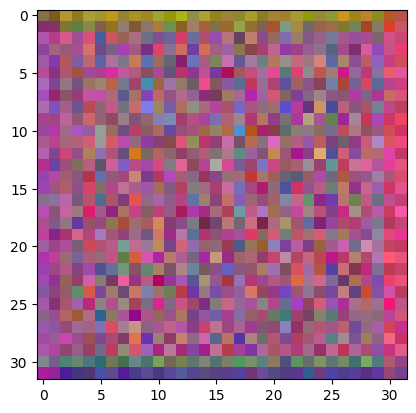

In [53]:
import numpy as np
import matplotlib.pyplot as plt

vector = np.random.normal(loc=0, scale=1, size=(1, 1, 64))
fake_batch = torch.tensor(vector, dtype=torch.float32)

print(fake_batch.max(), fake_batch.min())

generated_image = generator(fake_batch)

print(generated_image.max())

image = generated_image.to(torch.device("cpu"))
image = (image - image.min()) / (image.max() - image.min())
plt.imshow(image[0].permute(1, 2, 0).detach().numpy())
plt.show()


In [7]:
import gdown

file_id = "16yNwt9Lc9ZT2qYdXY6b0DBW66l2bTcg6"

url = f"https://drive.google.com/uc?id={file_id}"

output = "crawled_cakes.zip"

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=16yNwt9Lc9ZT2qYdXY6b0DBW66l2bTcg6
To: /content/crawled_cakes.zip
100%|██████████| 36.5M/36.5M [00:01<00:00, 34.4MB/s]


'crawled_cakes.zip'

In [8]:
import zipfile

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall("crawled_cakes")

In [9]:
import os
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch

data_dir = "crawled_cakes"

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = ImageFolder(data_dir, transform=transform)

all_images = images = torch.stack([img for img, _ in dataset])

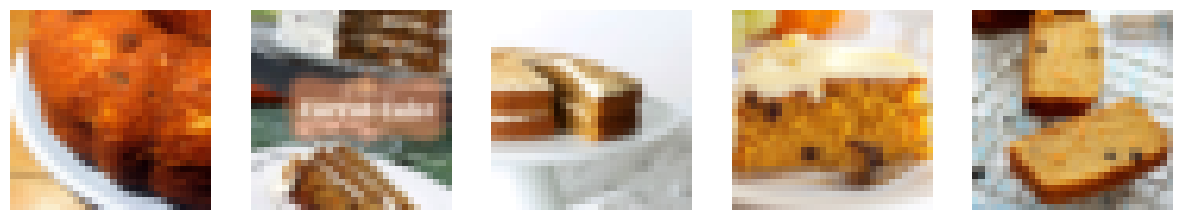

In [10]:
import matplotlib.pyplot as plt
import random

num_images_to_plot = 5

indices_to_plot = random.sample(range(len(all_images)), num_images_to_plot)

fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 5))

for i, index in enumerate(indices_to_plot):
    image = all_images[index].permute(1, 2, 0).numpy()
    image = (image - image.min()) / (image.max() - image.min())
    axes[i].imshow(image)
    axes[i].axis("off")

plt.show()

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(2, 3)
        self.fc2 = nn.Linear(3, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def custom_loss(output):
    return torch.mean((output - 42)**2)

def compute_gradients(loss, model):
    gradients = {}
    for param in model.fc1.parameters():
        gradient = torch.autograd.grad(loss, param, create_graph=True)
        gradients[param] = gradient[0]
    return gradients

def update_weights(model, gradients, learning_rate=0.01):
    with torch.no_grad():
        for param in model.fc1.parameters():
            param.data -= learning_rate * gradients[param]

model = SimpleModel()
optimizer = optim.SGD(model.parameters(), lr=0.01)

input_data = torch.rand(10, 2)

for _ in range(10):
    output = model(input_data)
    loss = custom_loss(output)

    gradients = compute_gradients(loss, model)
    update_weights(model, gradients)

    print("Loss:", loss.item())

Loss: 1761.0582275390625
Loss: 1752.9759521484375
Loss: 1744.4107666015625
Loss: 1735.561767578125
Loss: 1726.763427734375
Loss: 1718.015625
Loss: 1709.3177490234375
Loss: 1700.669677734375
Loss: 1692.0709228515625
Loss: 1683.521240234375


In [13]:
from operator import ge
from torch.utils.data import DataLoader
import numpy as np

batch_size = 32
real_data_loader = DataLoader(all_images, batch_size=batch_size, shuffle=True)
first_batch = next(iter(real_data_loader))

num_vectors = 32
vector_length = 64

vectors = np.random.normal(loc=0, scale=1, size=(num_vectors, 1, vector_length))

fake_batch = torch.tensor(vectors, dtype=torch.float32)
fake_batch = generator(fake_batch)
combined_images = torch.cat((first_batch, fake_batch), dim=0)

labels = torch.cat((torch.ones(batch_size, dtype=torch.float32), torch.zeros(batch_size, dtype=torch.float32)), 0)

for i in range(len(labels)):
    if(labels[i]):
      labels[i]-= 0.05
    else :
      labels[i] += 0.05

labels = labels.view(-1, 1)

In [55]:
criterion = nn.BCELoss()

generator.to(device)
discriminator.to(device)

optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=0.00001)
optimizer_generator = optim.Adam(generator.parameters(), lr=0.00001)

In [ ]:
import torch.nn as nn
import torch.optim as optim

# Discriminator one epoch
outputs = discriminator(combined_images.to(device))

loss_discriminator = criterion(outputs, labels.to(device))

loss_discriminator.to(device).backward()
optimizer_discriminator.step()

In [ ]:
# Generator one epoch
vectors = np.random.normal(loc=0, scale=1, size=(num_vectors, 1, vector_length))

fake_batch = torch.tensor(vectors, dtype=torch.float32)
fake_batch = generator(fake_batch)
labels = torch.ones(batch_size, dtype=torch.float32)
labels = labels.view(-1, 1)

outputs = discriminator(fake_batch.to(device))

loss_generator = criterion(outputs, labels)

loss_generator.backward()
optimizer_generator.step()

In [17]:
def run_epoch(epoch: int):
    generator.train()
    loss_generator = 0
    loss_discriminator = 0
    for n, real_samples in enumerate(real_data_loader):
        real_samples = real_samples.to(device)
        num_vectors = len(real_samples)
        real_samples_labels = torch.ones((num_vectors, 1)).to(device)
        latent_space_samples = torch.tensor(np.random.normal(loc=0, scale=1, size=(num_vectors, 1, vector_length)), dtype=torch.float32).to(device)
        generated_samples = generator(latent_space_samples)

        generated_samples_labels = torch.zeros((num_vectors, 1)).to(device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        optimizer_discriminator.zero_grad()
        output_discriminator = discriminator(all_samples.detach())
        loss_discriminator = criterion(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Training the generator
        optimizer_generator.zero_grad()
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = criterion(
            output_discriminator_generated, real_samples_labels
        )

        loss_generator.backward()
        optimizer_generator.step()

    return loss_generator, loss_discriminator

In [18]:
from google.colab import drive
from datetime import datetime
drive.mount('/content/drive')

def save_checkpoint(epoch, generator, discriminator, optimizer_generator, optimizer_discriminator, generator_loss, discriminator_loss, checkpoint_dir = "drive/MyDrive/GANs"):
    current_datetime = datetime.now().strftime("%Y%m%d%H%M%S")

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    generator_checkpoint = {
        'epoch': epoch,
        'model_state_dict': generator.state_dict(),
        'optimizer_state_dict': optimizer_generator.state_dict(),
        'generator_loss': generator_loss,
        'time': current_datetime
    }
    generator_checkpoint_path = os.path.join(checkpoint_dir, f'generator_epoch{epoch}')
    torch.save(generator_checkpoint, generator_checkpoint_path)

    discriminator_checkpoint = {
        'epoch': epoch,
        'model_state_dict': discriminator.state_dict(),
        'optimizer_state_dict': optimizer_discriminator.state_dict(),
        'discriminator_loss': discriminator_loss,
        'time': current_datetime
    }
    discriminator_checkpoint_path = os.path.join(checkpoint_dir, f'discriminator_epoch{epoch}')
    torch.save(discriminator_checkpoint, discriminator_checkpoint_path)

    return checkpoint_dir

def load_checkpoint(epoch, generator, discriminator, optimizer_generator, optimizer_discriminator, generator_loss, discriminator_loss, checkpoint_dir = "GANs"):
    generator_checkpoint_path = os.path.join(checkpoint_dir, f'generator_epoch{epoch}')
    if os.path.exists(generator_checkpoint_path):
        generator_checkpoint = torch.load(generator_checkpoint_path)
        generator.load_state_dict(generator_checkpoint['model_state_dict'])
        optimizer_generator.load_state_dict(generator_checkpoint['optimizer_state_dict'])
        generator_loss = generator_checkpoint['generator_loss']
        print(f'Loaded generator checkpoint from epoch {epoch}')

    discriminator_checkpoint_path = os.path.join(checkpoint_dir, f'discriminator_epoch{epoch}')
    if os.path.exists(discriminator_checkpoint_path):
        discriminator_checkpoint = torch.load(discriminator_checkpoint_path)
        discriminator.load_state_dict(discriminator_checkpoint['model_state_dict'])
        optimizer_discriminator.load_state_dict(discriminator_checkpoint['optimizer_state_dict'])
        discriminator_loss = discriminator_checkpoint['discriminator_loss']
        print(f'Loaded discriminator checkpoint from epoch {epoch}')

Mounted at /content/drive


In [35]:
def generate_vectors(num_vectors=9):
  vectors = np.random.normal(loc=0, scale=1, size=(num_vectors, 1, vector_length))
  fake_batch = torch.tensor(vectors, dtype=torch.float32).to(device)
  return fake_batch


def show_images(vectors):
  generated_images = generator(vectors)

  fig, axes = plt.subplots(3, 3, figsize=(8, 8))
  for i, ax in enumerate(axes.flat):
    image = generated_images[i].to(torch.device("cpu"))
    image = (image - image.min()) / (image.max() - image.min())
    ax.imshow(image.permute(1, 2, 0).detach().numpy())
    ax.axis('off')
  plt.show()


In [56]:
vectors = generate_vectors()

num_epochs = 3000
for epoch in range(num_epochs):
    loss_generator, loss_discriminator = run_epoch(epoch)
    if epoch % 50 == 0:
        print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
        print(f"Epoch: {epoch} Loss G.: {loss_generator}")
        save_checkpoint(epoch, generator, discriminator, optimizer_generator, optimizer_discriminator, loss_generator, loss_discriminator)
        show_images(vectors)

Output hidden; open in https://colab.research.google.com to view.

tensor(2.5024) tensor(-2.1158) tensor(0.8112, grad_fn=<MaxBackward1>) tensor(-0.8854, grad_fn=<MinBackward1>)


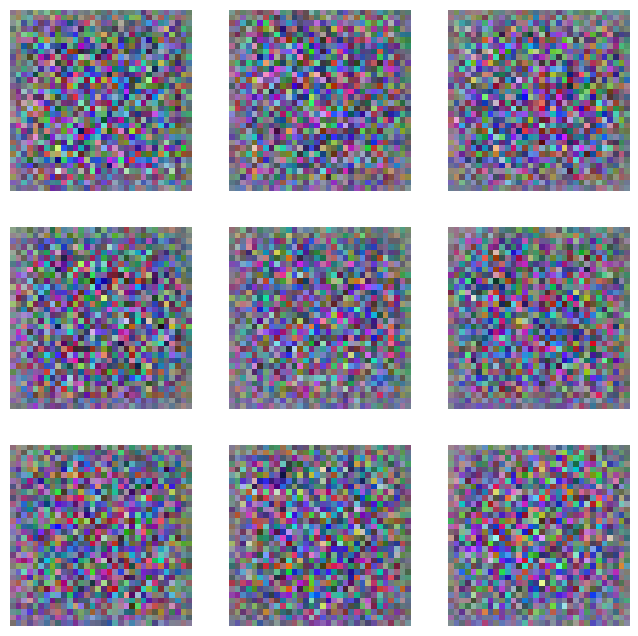

In [ ]:
vectors = generate_vectors()
# print(vectors)
show_images(vectors)